<img style="float: left;" src="resources/made.jpg" width="35%" height="35%"/>

# Семинар 1: PyTorch recap / аугментация / OpenCV
Преподаватель: Иван Карпухин, ведущий программист-исследователь команды машинного зрения Mail.ru Group.

<div style="clear: both;"></div>

Семинар состоит из двух частей. В первой мы применим классические методы регуляризации. Во второй сделаем аугментацию данных средствами OpenCV.

Для выполнения работы необходимы следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* albumentations

Установить их можно командой:
```bash
pip3 install opencv-python torch torchvision albumentations
```

In [1]:
from PIL import Image
import random

import albumentations
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torchvision
from torchvision.datasets import CIFAR10

import cvmade
import seminar

In [2]:
print(torch.__version__)

# Параметры тренировки:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Using CUDA")

TRAIN = True

TRAIN_KWARGS = {
    "plot": False,
    "train_plot_kwargs": {
        "c": "b"
    },
    "test_scatter_kwargs": {
        "c": "y",
        "s": 100,
        "zorder": 1e10
    },
    "use_cuda": USE_CUDA
}

1.7.1+cu101
Using CUDA


# Простая тренировка на CIFAR-10

## Подготовка данных

Если возникнут трудности при загрузке данных, можно скачать архив по ссылке и самостоятельно распаковать в папку с блокнотом, так, чтобы рядом с блокнотом появилась папка `cifar-10-batches-py`.

Ссылка на данные: https://cloud.mail.ru/public/2ku1/KJPEsJ6xR

Files already downloaded and verified
Files already downloaded and verified
Single image shape (CHW): [3, 32, 32]
Trainset size: 50000
Testset size: 10000
Trainset:


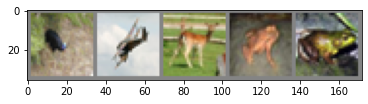

Testset:


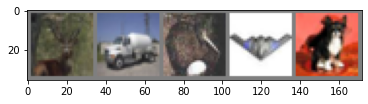

In [3]:
DATA_ROOT = "."

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # transform PIL-images to torch tensors
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset = CIFAR10(DATA_ROOT, train=True, download=True, transform=transform)
testset = CIFAR10(DATA_ROOT, train=False, download=True, transform=transform)
print("Single image shape (CHW):", list(testset[0][0].shape))
print("Trainset size:", len(trainset))
print("Testset size:", len(testset))

print("Trainset:")
cvmade.plot.torch.show_images_dataset(trainset)
print("Testset:")
cvmade.plot.torch.show_images_dataset(testset)

## Создание модели

Создадим сеть вида VGG (сокращение от Visual Geometry Group, https://arxiv.org/pdf/1409.1556.pdf).

Сеть VGG состоит из свёрток 3x3, ReLU, MaxPool и полносвязных слоёв. Оригинальная сеть VGG применялась к изображениям 224x224, мы же применяем к изображениям 32x32. В статье описаны варианты сети VGG с количеством слоёв от 11 до 19. Для задачи CIFAR10 достаточно меньшего числа слоёв. Итоговая сложность модели позволит нам учить сеть на CPU.

Заметьте, что после pooling-слоя площадь изображения уменьшается в четыре раза, а число каналов увеличивается в два раза, то есть размер тензора уменьшается в два раза. Баланс между размером изображения и числом каналов позволяет сохранить достаточное количество информации при продвижении по сети.

<img src="resources/vgg1.jpg" align="left" hspace="20" width="50%" height="50%"/> 
<img src="resources/vgg2.jpg" align="left" hspace="20" width="50%" height="50%"/>
<div style="clear: both;"></div>

Шпаргалка:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
                dilation=1, groups=1, bias=True, padding_mode='zeros')

torch.nn.ReLU(inplace=False)

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1,
                   return_indices=False, ceil_mode=False)

torch.nn.Linear(in_features, out_features, bias=True)
```

In [4]:
class VGGNetwork(torch.nn.Sequential):        
    def _make_conv3x3(self, in_channels, out_channels):
        layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3),
                                padding=1, padding_mode='zeros')
        return layer

    def _make_relu(self):
        layer = torch.nn.ReLU()
        return layer

    def _make_maxpool2x2(self):
        layer = torch.nn.MaxPool2d((2, 2), stride=2)
        return layer

    def _make_fully_connected(self, in_features, out_features, last=False):
        layer = torch.nn.Linear(in_features, out_features)
        return layer

    def __init__(self, n_classes=10):
        # We use "same" padding to preserve image width and height.
        # They only change (reduce by half) in MaxPool layer.
        layers = [
            self._make_conv3x3(in_channels=3, out_channels=32),
            self._make_conv3x3(in_channels=32, out_channels=32),
            self._make_relu(),
            self._make_maxpool2x2(),

            self._make_conv3x3(in_channels=32, out_channels=64),
            self._make_conv3x3(in_channels=64, out_channels=64),
            self._make_relu(),
            self._make_maxpool2x2(),

            self._make_conv3x3(in_channels=64, out_channels=128),
            self._make_conv3x3(in_channels=128, out_channels=128),
            self._make_relu(),
            self._make_maxpool2x2(),

            self._make_conv3x3(in_channels=128, out_channels=256),
            self._make_conv3x3(in_channels=256, out_channels=256),
            self._make_relu(),
            self._make_maxpool2x2(),

            # Convert 4-dimensional BHWC tensor to 2-dimensional BD tensor:
            torch.nn.modules.Flatten(),

            self._make_fully_connected(in_features=256 * 2 * 2,
                                       out_features=512),
            self._make_fully_connected(in_features=512, out_features=512),
            self._make_fully_connected(in_features=512, out_features=n_classes,
                                       last=True)
        ]
        super().__init__(*layers)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out",
                                              nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total

vgg = VGGNetwork()
print(vgg)
print("Total parameters: {}".format(count_parameters(vgg)))

seminar.check_vgg(VGGNetwork)

VGGNetwork(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_

## Обучение

Воспользуемся оптимизацией с моментом Нестерова. Будем использовать момент, равный 0.9, и начальный шаг обучения 0.01.

Шпаргалка:

```python
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100,
                          reduce=None, reduction='mean')

torch.optim.SGD(params, lr, momentum=0, dampening=0, weight_decay=0,
                nesterov=False)
```

In [5]:
def make_loss():
    loss = torch.nn.CrossEntropyLoss()
    return loss

def make_optimizer(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                                momentum=0.9, nesterov=True)
    return optimizer

seminar.check_loss_fn(make_loss)
seminar.check_optimizer_fn(make_optimizer)

CHECK OK
CHECK OK


Используем экспоненциально затухающий learning rate.

График изменения learning rate:


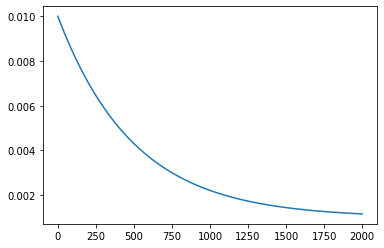

In [6]:
def lr(step):
    return 0.1 + 0.9 * (0.998) ** step

def make_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

xs = np.linspace(0, 2000)
print("График изменения learning rate:")
plt.plot(xs, 0.01 * lr(xs))
plt.show()

In [7]:
if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/01-simple-train.jpg")

Test loss: 2.302549391937256
Test accuracy: 0.1133
Step 0
Train loss: 1.9789, learning rate: 0.0065
Test loss: 1.9194444255828857
Test accuracy: 0.2877
Step 250
Train loss: 1.6851, learning rate: 0.0043
Test loss: 1.7059566200256349
Test accuracy: 0.3439
Step 500
Train loss: 1.6169, learning rate: 0.0030
Test loss: 1.5567494135856628
Test accuracy: 0.4229
Step 750
Train loss: 1.3985, learning rate: 0.0022
Test loss: 1.3397812570571899
Test accuracy: 0.5102
Step 1000
Train loss: 1.3658, learning rate: 0.0017
Test loss: 1.3616288411140443
Test accuracy: 0.5035
Step 1250
Train loss: 1.3572, learning rate: 0.0014
Test loss: 1.2218451246261597
Test accuracy: 0.5612
Step 1500
Train loss: 1.1779, learning rate: 0.0013
Test loss: 1.1919868425369262
Test accuracy: 0.5601
Step 1750
Train loss: 1.3001, learning rate: 0.0012
Test loss: 1.1550823616027832
Test accuracy: 0.5831


# Batchnorm

Batchnorm (https://arxiv.org/pdf/1502.03167.pdf) — это техника улучшения сходимости сетей с большим количеством слоёв.

Во время тренировки:

<img src="resources/batchnorm.jpg" align="left" width="40%" height="40%"/>
<div style="clear: both;"></div>

Во время применения модели статистики по батчу заменяются на более точные статистики по корпусу данных.

Шпаргалка:

```python
torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True,
                     track_running_stats=True)
```

In [8]:
class VGGNetworkBN(VGGNetwork):
    @staticmethod
    def _make_conv3x3(in_channels, out_channels):
        conv_layer = torch.nn.Conv2d(in_channels, out_channels, 3,
                                     padding=1, bias=0)
        batchnorm_layer = torch.nn.BatchNorm2d(out_channels)
        return torch.nn.Sequential(conv_layer, batchnorm_layer)

vgg_bn = VGGNetworkBN()
print(vgg_bn)
seminar.check_vgg_bn(VGGNetworkBN)

VGGNetworkBN(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_m

In [9]:
if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/02-batchnorm.jpg")

Test loss: 2.3027535800933836
Test accuracy: 0.1
Step 0
Train loss: 1.6620, learning rate: 0.0065
Test loss: 1.6473230499267577
Test accuracy: 0.3877
Step 250
Train loss: 1.5628, learning rate: 0.0043
Test loss: 1.454315664100647
Test accuracy: 0.4604
Step 500
Train loss: 1.3898, learning rate: 0.0030
Test loss: 1.2583318169593811
Test accuracy: 0.5367
Step 750
Train loss: 1.0492, learning rate: 0.0022
Test loss: 1.19674926738739
Test accuracy: 0.5645
Step 1000
Train loss: 1.1406, learning rate: 0.0017
Test loss: 1.1431115800380707
Test accuracy: 0.5891
Step 1250
Train loss: 1.1357, learning rate: 0.0014
Test loss: 1.0941871103286742
Test accuracy: 0.6041
Step 1500
Train loss: 1.1377, learning rate: 0.0013
Test loss: 1.0562859872341157
Test accuracy: 0.6191
Step 1750
Train loss: 1.0009, learning rate: 0.0012
Test loss: 0.9933493067264557
Test accuracy: 0.6472


# Переобучение

Из соображений производительности мы используем небольшую сеть. На CIFAR10 она не переобучается. Чтобы воспроизвести ситуацию с переобучением, мы уменьшим количество тренировочных данных.

In [10]:
TRAIN_SUBSET_SIZE = 5000

trainset_small_indices = random.sample(list(range(len(trainset))),
                                       TRAIN_SUBSET_SIZE)
trainset_small = torch.utils.data.Subset(trainset, trainset_small_indices)
print("Small trainset size:", len(trainset_small))

Small trainset size: 5000


In [11]:
if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/03-overfit.jpg")

Test loss: 2.3026253551483156
Test accuracy: 0.1128
Step 0
Train loss: 1.8634, learning rate: 0.0065
Test loss: 2.021864616584778
Test accuracy: 0.2526
Step 250
Train loss: 1.6372, learning rate: 0.0043
Test loss: 1.610269358062744
Test accuracy: 0.3757
Step 500
Train loss: 1.3711, learning rate: 0.0030
Test loss: 1.437320447063446
Test accuracy: 0.4653
Step 750
Train loss: 1.0441, learning rate: 0.0022
Test loss: 1.3880892420768738
Test accuracy: 0.4995
Step 1000
Train loss: 1.1203, learning rate: 0.0017
Test loss: 1.3754327927589416
Test accuracy: 0.5125
Step 1250
Train loss: 1.0555, learning rate: 0.0014
Test loss: 1.404241826057434
Test accuracy: 0.5125
Step 1500
Train loss: 0.7176, learning rate: 0.0013
Test loss: 1.4728713031291962
Test accuracy: 0.525
Step 1750
Train loss: 0.5813, learning rate: 0.0012
Test loss: 1.5152361372470855
Test accuracy: 0.5429


## L2-регуляризация (регуляризация Тихонова)

К функции потерь добавляется сумма квадратов параметров модели с некотрым весом (weight decay). В итоге модель штрафуется за слишком большие веса модели. Ограничение на диапазон значений параметров приводит к уменьшению переобучения.

In [12]:
WEIGHT_DECAY = 0.01

def make_optimizer_l2_reg(model):
    return torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
                           nesterov=True, weight_decay=WEIGHT_DECAY)

if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer_l2_reg,
                        trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/04-l2.jpg")

Test loss: 2.302757472229004
Test accuracy: 0.0995
Step 0
Train loss: 2.0234, learning rate: 0.0065
Test loss: 1.9541485683441162
Test accuracy: 0.2347
Step 250
Train loss: 1.7328, learning rate: 0.0043
Test loss: 1.9064839477539062
Test accuracy: 0.247
Step 500
Train loss: 1.7312, learning rate: 0.0030
Test loss: 1.7833880416870118
Test accuracy: 0.3068
Step 750
Train loss: 1.7482, learning rate: 0.0022
Test loss: 1.7435985774993896
Test accuracy: 0.3216
Step 1000
Train loss: 1.5776, learning rate: 0.0017
Test loss: 1.72640239944458
Test accuracy: 0.3409
Step 1250
Train loss: 1.6229, learning rate: 0.0014
Test loss: 1.6671271451950074
Test accuracy: 0.3583
Step 1500
Train loss: 1.6576, learning rate: 0.0013
Test loss: 1.6536695795059204
Test accuracy: 0.3638
Step 1750
Train loss: 1.5666, learning rate: 0.0012
Test loss: 1.6167132663726806
Test accuracy: 0.37


# Dropout

Свёртки содержат мало параметров, они не переобучаются, поэтому Dropout обычно используют в полносвязных слоях.

In [13]:
class VGGNetworkDO(VGGNetwork):
    @staticmethod
    def _make_fully_connected(in_features, out_features, last=False):
        layers = [torch.nn.Linear(in_features, out_features)]
        if not last:
            layers.append(torch.nn.Dropout(p=0.85))
        return torch.nn.Sequential(*layers)

vgg_do = VGGNetworkDO()
print(vgg_do)
seminar.check_vgg_do(VGGNetworkDO)

VGGNetworkDO(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, cei

In [14]:
if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg_do, make_loss, make_optimizer,
                        trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/05-dropout.jpg")

Test loss: 2.3027652896881103
Test accuracy: 0.0952
Step 0
Train loss: 2.1176, learning rate: 0.0065
Test loss: 2.0957633779525757
Test accuracy: 0.1923
Step 250
Train loss: 1.9987, learning rate: 0.0043
Test loss: 1.8777366678237914
Test accuracy: 0.2402
Step 500
Train loss: 1.7303, learning rate: 0.0030
Test loss: 1.730153538131714
Test accuracy: 0.3159
Step 750
Train loss: 1.7475, learning rate: 0.0022
Test loss: 1.6833374923706055
Test accuracy: 0.355
Step 1000
Train loss: 1.5534, learning rate: 0.0017
Test loss: 1.6540731216430664
Test accuracy: 0.3705
Step 1250
Train loss: 1.5851, learning rate: 0.0014
Test loss: 1.5438707124710083
Test accuracy: 0.4118
Step 1500
Train loss: 1.3256, learning rate: 0.0013
Test loss: 1.5018344140052795
Test accuracy: 0.4338
Step 1750
Train loss: 1.4440, learning rate: 0.0012
Test loss: 1.467273445224762
Test accuracy: 0.4412


## Аугментация

Мы используем следующие аугментации:
1. Rotation / Scale / Offset
2. Random crop
3. Brightness / Contrast
4. Blur

Шпаргалка:
```python
# center: (x, y), angle: degrees, scale: number
cv2.getRotationMatrix2D(center, angle, scale)

cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])
```

Files already downloaded and verified


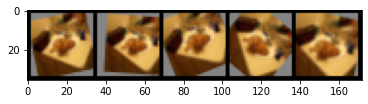

In [15]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_scale=1.1, max_offset=0.1):
        self._min_scale = min_scale
        self._max_scale = max_scale
        self._max_offset = max_offset

    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy
        h, w, c = image.shape
        assert c == 3

        angle = random.random() * 90 - 45
        scale = self._min_scale + random.random() * (self._max_scale
                                                     - self._min_scale)
        x_offset = random.randint(-int(self._max_offset * w),
                                  int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h),
                                  int(self._max_offset * h))

        # Transform the image using given angle, scale and (x_offset, y_offset).
        # Fill background with gray color.
        transform = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
        transform[0, 2] += x_offset
        transform[1, 2] += y_offset

        new_image = cv2.warpAffine(image, transform, (w, h),
                                   borderValue=(128, 128, 128))

        return Image.fromarray(new_image)  # Numpy -> PIL


%matplotlib inline
seminar.show_augmenter_results(AffineAugmenter(), DATA_ROOT)

Пример:
<div style="clear: both;"></div>
<img style="float: left;" src="resources/aug-00-affine.jpg" width="40%" height="40%">
<div style="clear: both;"></div>

In [16]:
augmentation_transform = torchvision.transforms.Compose([
    AffineAugmenter(),
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True,
            transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer,
                        trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/07-aug-affine.jpg")

Files already downloaded and verified
Trainset size: 5000
Test loss: 2.30289006729126
Test accuracy: 0.1
Step 0
Train loss: 1.9740, learning rate: 0.0065
Test loss: 1.7326780241012574
Test accuracy: 0.3547
Step 250
Train loss: 1.7332, learning rate: 0.0043
Test loss: 1.5970352053642274
Test accuracy: 0.4014
Step 500
Train loss: 1.4393, learning rate: 0.0030
Test loss: 1.4334429206848145
Test accuracy: 0.4647
Step 750
Train loss: 1.4000, learning rate: 0.0022
Test loss: 1.3948321445465088
Test accuracy: 0.4895
Step 1000
Train loss: 1.4596, learning rate: 0.0017
Test loss: 1.38338039188385
Test accuracy: 0.4973
Step 1250
Train loss: 1.3423, learning rate: 0.0014
Test loss: 1.3486412719726562
Test accuracy: 0.5117
Step 1500
Train loss: 1.5098, learning rate: 0.0013
Test loss: 1.3038938694000244
Test accuracy: 0.5278
Step 1750
Train loss: 1.2627, learning rate: 0.0012
Test loss: 1.4199991731643677
Test accuracy: 0.5001


Шпаргалка:
```(python)
cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
```

Files already downloaded and verified


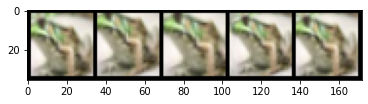

In [17]:
class CropAugmenter(object):
    def __init__(self, min_scale=0.8):
        self._min_scale = min_scale

    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy
        h, w, c = image.shape
        assert c == 3
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        new_w = int(scale * w)
        new_h = int(scale * h)
        x = random.randint(0, w - new_w)
        y = random.randint(0, h - new_h)

        # Create new_image from image by shifting it by (x, y)
        # and cropping to size (new_w, new_h). The size is then
        # upscaled back to (w, h).
        new_image = image[y:y + new_h, x:x + new_w]
        new_image = cv2.resize(new_image, (w, h))

        return Image.fromarray(new_image)  # Numpy -> PIL

%matplotlib inline
seminar.show_augmenter_results(CropAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-01-crop.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified


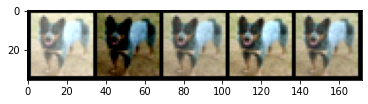

In [18]:
class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness  # [-1, 1]
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast  # [0, 2]

        new_image = image.astype(np.float32) / 255.0
        new_image = contrast * (new_image - 0.5) + 0.5 + brightness
        new_image = np.clip(new_image * 255, 0, 255).astype(np.uint8)

        assert new_image.dtype == np.uint8
        return Image.fromarray(new_image)  # Numpy -> PIL

%matplotlib inline
seminar.show_augmenter_results(BrightnessContrastAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-02-color.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Шпаргалка:
    
```python
# ksize: (w, h), sigmaX: number
cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])
```

Files already downloaded and verified


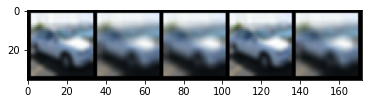

In [19]:
class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image
        image = np.array(image)  # PIL -> Numpy
        h, w, c = image.shape
        assert c == 3

        new_image = cv2.GaussianBlur(image, (kernel, kernel), kernel / 2.)

        return Image.fromarray(new_image)  # Numpy -> PIL
    
%matplotlib inline
seminar.show_augmenter_results(BlurAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-03-blur.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified


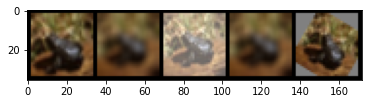

In [20]:
class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image):
        augmenter = random.choice(self._augmenters)
        return augmenter(image)

augmenter = RandomAugmentation(AffineAugmenter(),
                               CropAugmenter(),
                               BrightnessContrastAugmenter(),
                               BlurAugmenter())

%matplotlib inline
seminar.show_augmenter_results(augmenter, DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-04-random.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

In [21]:
augmentation_transform = torchvision.transforms.Compose([
    augmenter,
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True,
            transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/08-aug-all.jpg")

Files already downloaded and verified
Trainset size: 5000
Test loss: 2.303377341079712
Test accuracy: 0.1
Step 0
Train loss: 1.8341, learning rate: 0.0065
Test loss: 1.8520140916824341
Test accuracy: 0.2886
Step 250
Train loss: 1.6141, learning rate: 0.0043
Test loss: 1.483926988697052
Test accuracy: 0.4503
Step 500
Train loss: 1.4365, learning rate: 0.0030
Test loss: 1.3995798720359802
Test accuracy: 0.4859
Step 750
Train loss: 1.3760, learning rate: 0.0022
Test loss: 1.3187618638038636
Test accuracy: 0.5203
Step 1000
Train loss: 1.4459, learning rate: 0.0017
Test loss: 1.2963513838768006
Test accuracy: 0.5288
Step 1250
Train loss: 1.2190, learning rate: 0.0014
Test loss: 1.2645814326286315
Test accuracy: 0.5403
Step 1500
Train loss: 1.1272, learning rate: 0.0013
Test loss: 1.207917007446289
Test accuracy: 0.5562
Step 1750
Train loss: 0.9687, learning rate: 0.0012
Test loss: 1.287359977054596
Test accuracy: 0.5466


# Albumentations

Большинство стандартных аугментаций уже реализовано в сторонних библиотеках.

В `torchvision` классы трансформаций принимают изображение и возвращают изображение.

Классы трансформаций в `albumentations` принимают `kwargs` и возвращают словарь. За счёт этого `albumentations` может обрабатывать и изображения, и метки.

`albumentations` не принимает PIL, нужно конверитровать в Numpy.

Files already downloaded and verified


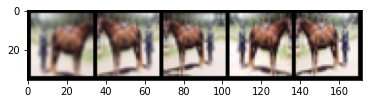

In [22]:
augmenter = albumentations.Compose([
    albumentations.ShiftScaleRotate(rotate_limit=0.25, p=0.7),
    albumentations.RandomBrightnessContrast(p=0.4),
    albumentations.RandomGamma(p=0.4),
    albumentations.Blur(blur_limit=2, p=0.1),
    albumentations.GaussNoise((10, 100), p=0.2),
    albumentations.HorizontalFlip(p=0.5)
])
%matplotlib inline
seminar.show_augmenter_results(
    lambda image: augmenter(image=np.array(image))["image"], DATA_ROOT
)

In [23]:
augmentation_transform = torchvision.transforms.Compose([
    lambda image: augmenter(image=np.array(image))["image"],
    transform
])

trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True,
            transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Включить интерактивные графики:
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer,
                        trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики:
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/09-aug-album.jpg")

Files already downloaded and verified
Trainset size: 5000
Test loss: 2.3030279731750487
Test accuracy: 0.1054
Step 0
Train loss: 1.6770, learning rate: 0.0065
Test loss: 1.7023403544425963
Test accuracy: 0.3784
Step 250
Train loss: 1.5569, learning rate: 0.0043
Test loss: 1.4303898203849792
Test accuracy: 0.4665
Step 500
Train loss: 1.3678, learning rate: 0.0030
Test loss: 1.3635373953819274
Test accuracy: 0.4978
Step 750
Train loss: 1.2841, learning rate: 0.0022
Test loss: 1.244059407901764
Test accuracy: 0.5462
Step 1000
Train loss: 1.3097, learning rate: 0.0017
Test loss: 1.183350402021408
Test accuracy: 0.5676
Step 1250
Train loss: 0.9840, learning rate: 0.0014
Test loss: 1.148932801914215
Test accuracy: 0.5926
Step 1500
Train loss: 0.9085, learning rate: 0.0013
Test loss: 1.2068790416240691
Test accuracy: 0.5802
Step 1750
Train loss: 0.9727, learning rate: 0.0012
Test loss: 1.109663072681427
Test accuracy: 0.6076
